# The main task is find dependation between 2 features (average month temperature, month number) and monthly electricity usage.

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [246]:
energy = pd.read_csv('elusage.csv', index_col = False)
energy.head(10)

,average_temperature,month,average_electricity_usage
0,73,8,24.828
1,67,9,24.688
2,57,10,19.310
3,43,11,59.706
4,26,12,99.667
5,41,1,49.333
6,38,2,59.375
7,46,3,55.172
8,54,4,55.517
9,60,5,25.938


### Getting informations about DataFrame (e.g. inproper/missing values and types of data used)

In [247]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   average_temperature        55 non-null     int64  
 1   month                      55 non-null     int64  
 2   average_electricity_usage  55 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.4 KB


#### **There are no missing values and all of them are numeric types**

### After DataFrame was made and check we need to give it as simple form as possible, so we will make column names shorter by removing useless `'average_'` substring (we know that every number in these 2 columns are the average values calculated from many observations taken during every month).

In [248]:
energy = energy.rename(columns={'average_temperature': 'temperature',
                                'average_electricity_usage': 'electricity_usage'})
energy.head()

,temperature,month,electricity_usage
0,73,8,24.828
1,67,9,24.688
2,57,10,19.310
3,43,11,59.706
4,26,12,99.667


---

## Global plot settings as a function

In [249]:
def global_plot_sets():
    plt.rc('xtick', color = 'k', labelsize = 18)
    plt.rc('ytick', color = 'k', labelsize = 18)
    plt.rc('axes', labelsize = 24, labelpad = 18, titlepad = 12,
           titlesize = 28, facecolor = '#CDCCC9', axisbelow = 'True')
    plt.rc('grid', color = 'w', linestyle = '-.', linewidth = 0.75)
    plt.rc('legend', facecolor = 'w', fontsize = 16)
    plt.rc('xtick.major', size = 8, width = 1)
    plt.rc('xtick.minor', size = 5, width = 1)
    plt.rc('ytick.major', size = 8, width = 1)
    plt.rc('ytick.minor', size = 5, width = 1)

## Graphical dependancy between measured data

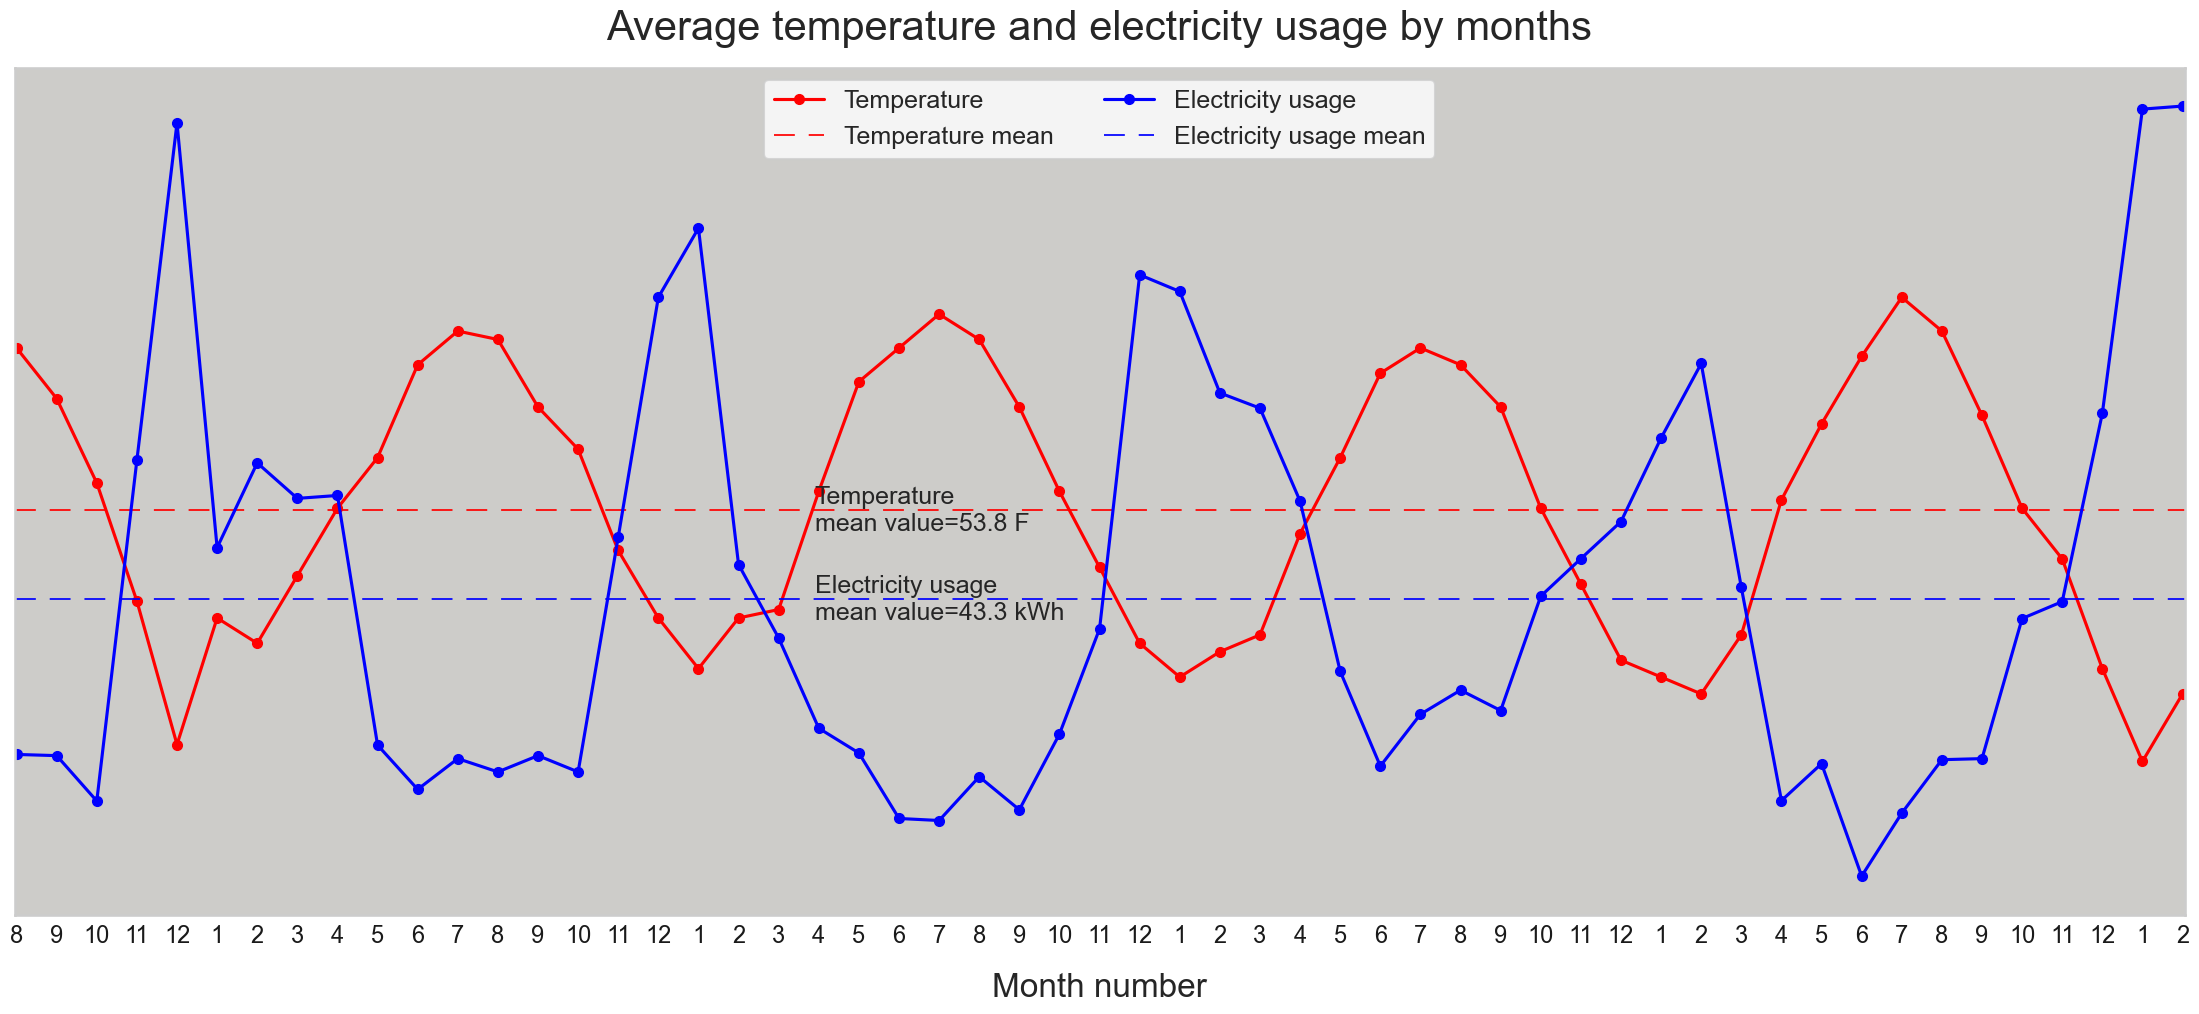

In [250]:
global_plot_sets()

plt.figure(figsize=(28, 11))

x_range = np.arange(1, energy.shape[0] + 1)
xticks_range = energy['month'].values
columns_list = ['temperature', 'electricity_usage']
colors_list = ['red', 'blue']
units_list = ['F', 'kWh']

for col_name, color, unit in zip(columns_list, colors_list, units_list):
    # Change column list into strings: 'Temperature', 'Electricity usage'
    label_name = ' '.join(str.capitalize(col_name).split('_'))
    mean = np.mean(energy[col_name])

    plt.plot(x_range, energy[col_name], c=color,
             marker='o', markersize=7, label=f"{label_name}")
    plt.axhline(y=mean, color=color,
                ls=(0, (12, 8)), lw=1.25, label=f"{label_name} mean")
    plt.text(0.38*len(energy), mean-2.5, f"{label_name}\nmean value={str(round(mean, 1))} {unit}",
             fontdict={'fontsize': 18})

plt.xlabel('Month number')
## give some margin for line plots
plt.xlim(x_range.min() - 0.05, x_range.max() + 0.05)
plt.xticks(x_range, xticks_range, fontsize=17)
plt.tick_params(axis='x', length=8, width=2, direction='inout')
plt.yticks([]) ## Labels replaced by the legend
plt.grid([])   ## no grid makes plot easier to read
plt.title('Average temperature and electricity usage by months',
          fontsize=30, pad=20)
plt.legend(loc='upper center', fontsize=18, ncol=2)  ## legend descriptions is too high

plt.show()

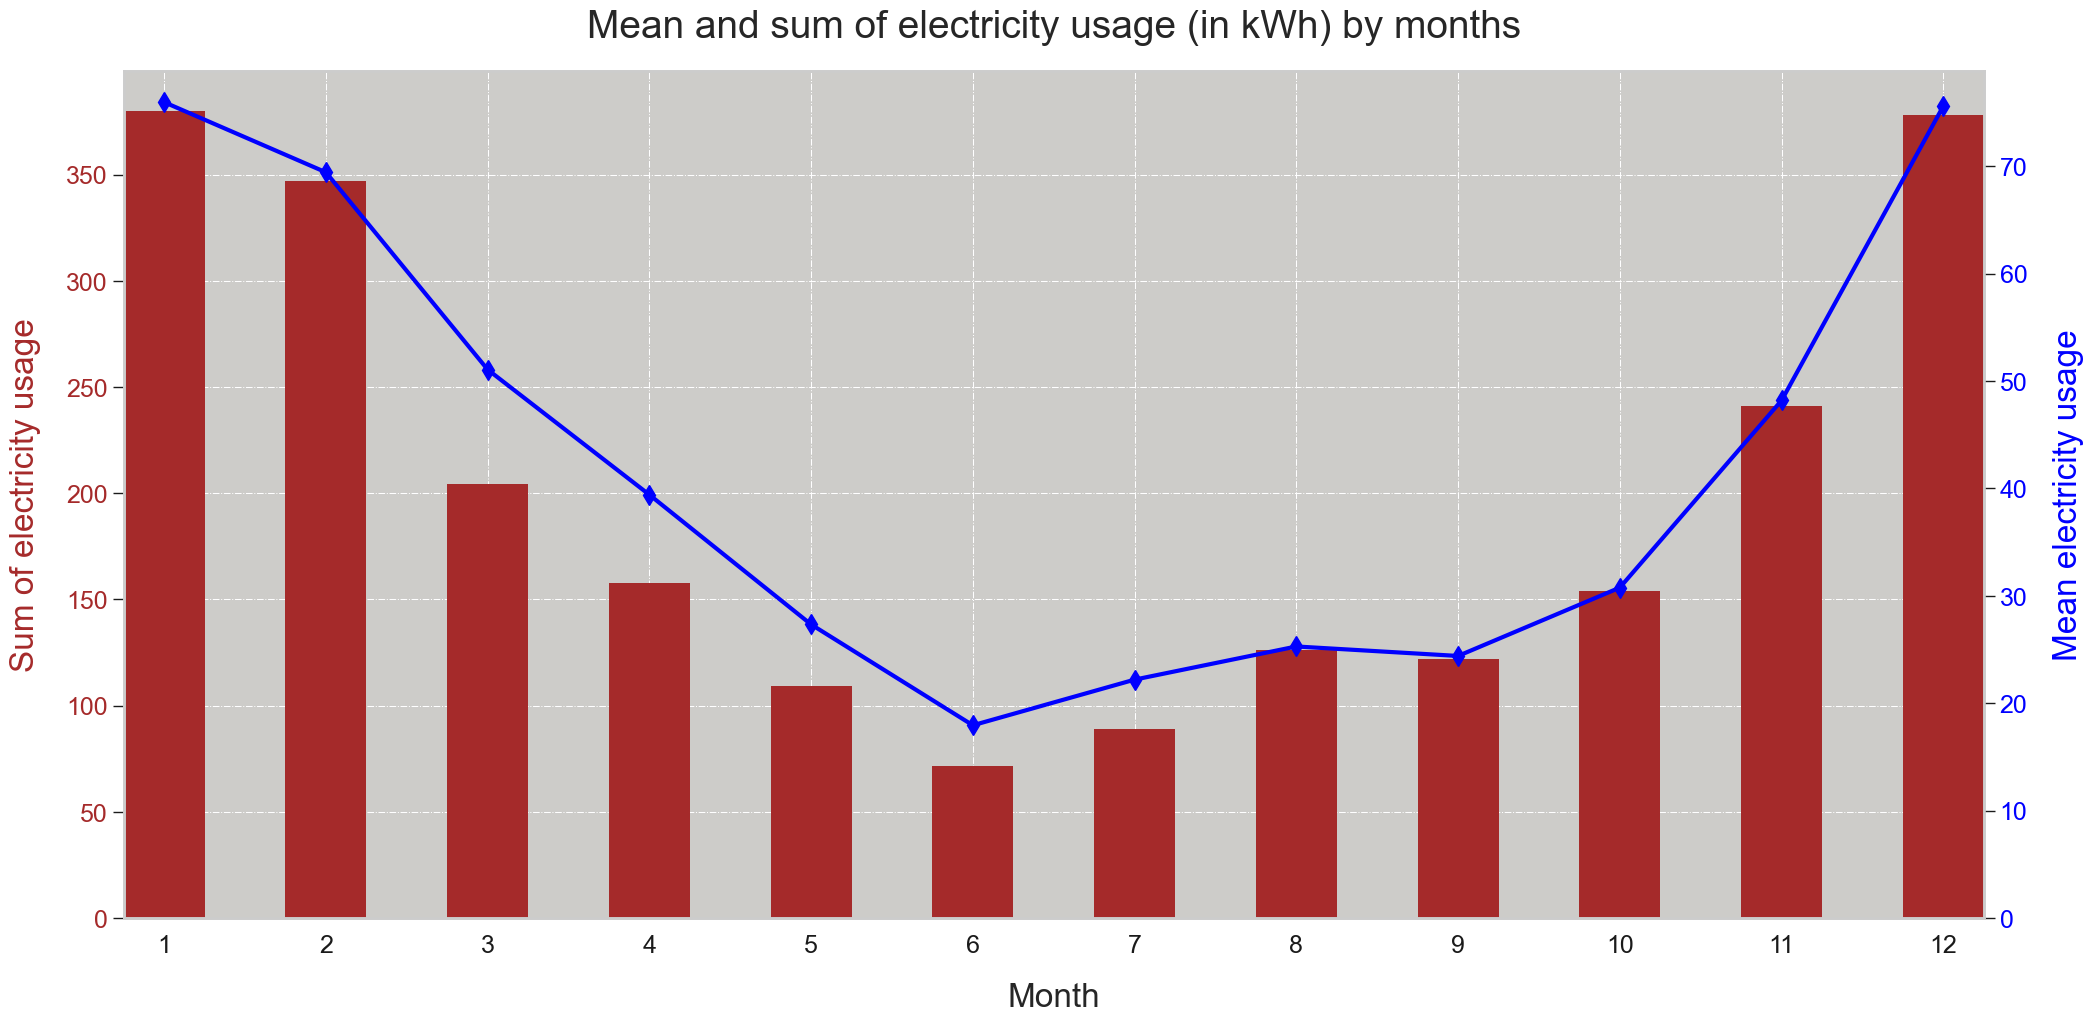

In [251]:
fig, ax1 = plt.subplots(figsize=(24, 11))
ax2 = ax1.twinx()

# Mean and sum values for every month of the year
months_mean_energy_used = energy.groupby('month')['electricity_usage'].mean()
months_sum_energy_used = energy.groupby('month')['electricity_usage'].sum()

month_number = months_sum_energy_used.keys()
w = 0.5   # bar width

ax1.bar(month_number, months_sum_energy_used, width = w, color = 'brown', linewidth=0)
ax2.plot(month_number, months_mean_energy_used, color = 'blue', linewidth=3, marker='d', markersize=10)
ax1.set_xlabel('Month')
ax1.set_ylabel('Sum of electricity usage', color='brown')
ax1.set_xlim((min(month_number) - 0.5*w, max(month_number) + 0.5*w))
ax1.tick_params(axis='y', labelcolor='brown')
ax1.set_xticks(month_number)    
ax2.set_ylabel('Mean electricity usage', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(ymin=0)
plt.grid(visible=False, axis='both')
plt.title('Mean and sum of electricity usage (in kWh) by months', y=1.02)

plt.show()

---

# **Statistics for data set**

### Looking for **Pearson** and **Spearman** correlations

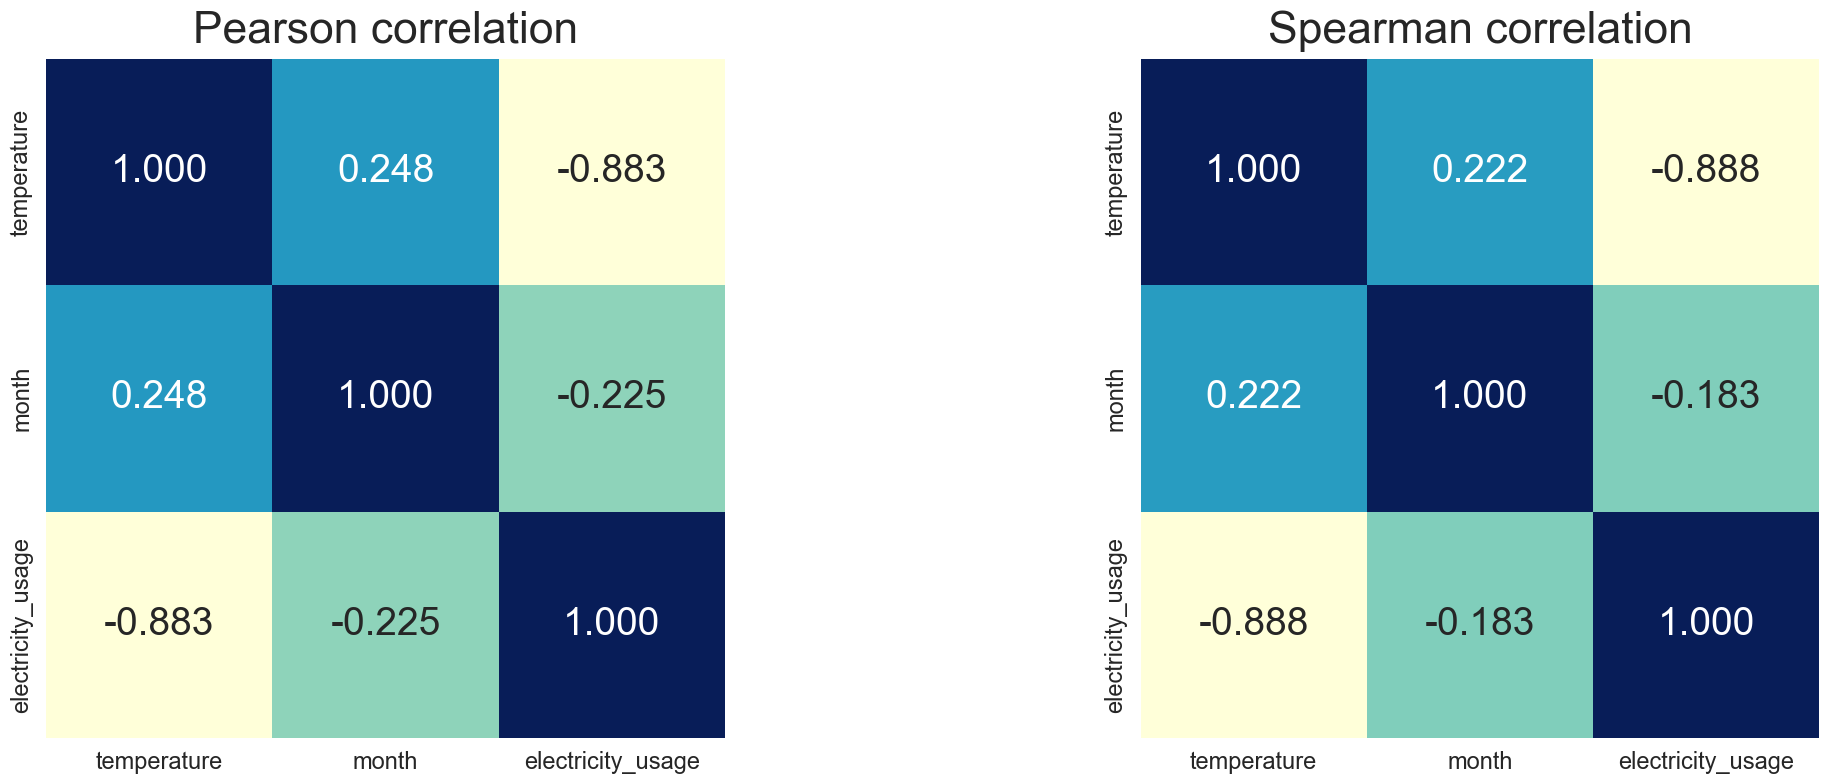

In [252]:
sns.set()

# Draw a heatmap with the numeric values in each cell
fig = plt.figure(figsize=(24, 8))

ax_ = [fig.add_subplot(1, 2, pos) for pos in [1,2]]
correlation_data = [energy.corr(method = option) for option in ['pearson', 'spearman']]
titles_array = ['Pearson correlation', 'Spearman correlation']

# We use axs parameter to tell seaborn which subplot to use for this plot
for axs, data, titles in zip(ax_, correlation_data, titles_array):
    sns.heatmap(data = data, square = True, cmap = "YlGnBu", cbar=False,
                fmt = '.3f', annot = True, annot_kws = {"fontsize": 28}, ax = axs)
    axs.set_xticklabels(ax_[0].get_xticklabels(), fontsize = 17)
    axs.set_yticklabels(ax_[0].get_xticklabels(), fontsize = 17)
    axs.set_title(titles, fontsize = 32)
    
plt.tight_layout()
plt.show()

## **Conclusions:** 
#### - `'month'` vs. `'electricity usage'` do not have enough strong linear and non-linear correlations, although plot show their cyclical (seasonal) dependancy,
#### - `'temperature'` and `'electricity_usage'` have got strong ***Spearman correlation***.

## Compare basic stats for `'temperature'` and `'electricity_usage'` data

<Figure size 2000x1200 with 0 Axes>

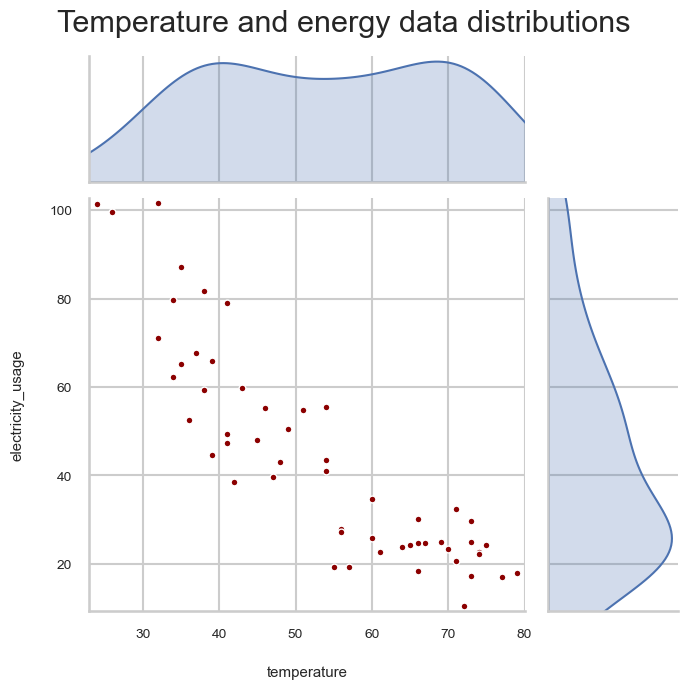

In [253]:
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=0.6)
plt.figure(figsize=(20, 12))

g = sns.JointGrid(data=energy, x='temperature', y='electricity_usage', height=7, ratio=3)
g.plot_joint(sns.scatterplot, alpha=1, color="darkred", linewidth=1, s=24)
g.ax_marg_x.set_xlim((energy['temperature'].min()-1, energy['temperature'].max()+1))
g.ax_marg_y.set_ylim((energy['electricity_usage'].min()-1, energy['electricity_usage'].max()+1))
g.plot_marginals(sns.kdeplot, fill=True)
sns.despine()
g.fig.suptitle('Temperature and energy data distributions', fontsize=22)
g.fig.subplots_adjust(top=1) # Reduce plot to make room
g.fig.tight_layout()

plt.show()

### Data from `'temperature'` column is close to normal distribution, but `'electricity_usage'` is right-skewed (the largest number of observations are on the left side of histogram). `'electricity_usage'` column will be transform by using 4 functions:
- BoxCox (*normalization*),
- RobustScaler,
- QuantileTransformer,
- minmax_scale.

In [254]:
from sklearn.preprocessing import minmax_scale, RobustScaler, QuantileTransformer, PowerTransformer

def data_transformations(data_name):
    # Results to compare
    original_data = data_name.values
    # reshape data to make .fit_transform() operations
    data_reshape = np.array(original_data).reshape(-1,1)
    
    func_1 = PowerTransformer(method='box-cox').fit_transform(data_reshape)[:,0]
    func_2 = RobustScaler(quantile_range=(25, 75)).fit_transform(data_reshape)[:,0]
    func_3 = QuantileTransformer(output_distribution='normal', 
                                 n_quantiles=len(data_name)).fit_transform(data_reshape)[:,0]
    func_4 = minmax_scale(original_data)
    
    # Create and return Dataframe with all data
    functions_list = np.array([original_data, func_1, func_2, func_3, func_4]).T
    function_titles = ['Original data', 'PowerTransformer data', 'RobustScaler data',
                       'Normalized data', 'MinMax_scale data']
    return pd.DataFrame(functions_list, columns = function_titles)    

df_transformed_data = data_transformations(energy['electricity_usage'])

### Compare original data with data transformed by statistical method(functions)

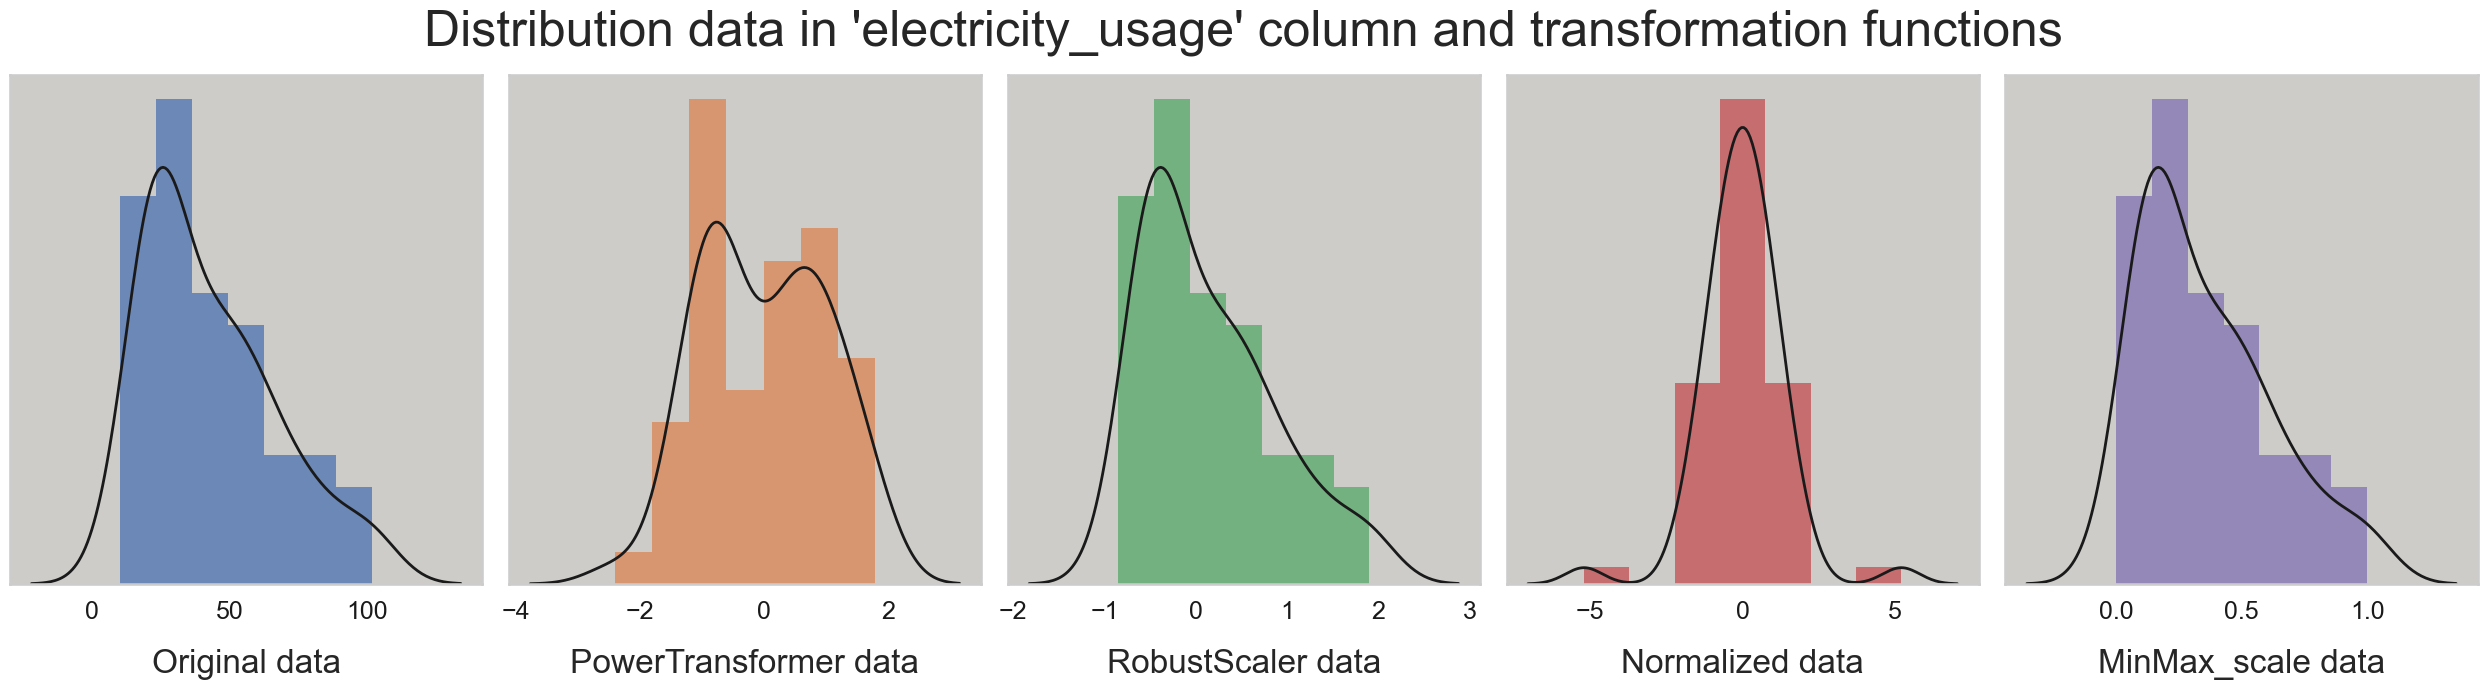

In [255]:
global_plot_sets()
fig, ax = plt.subplots(1, 5, figsize=(25, 7), sharey=False)

## Optimal number of bins
bin_num = int(np.sqrt(energy.shape[0]))

for i in range(0, df_transformed_data.shape[1]):
    sns.histplot(data=df_transformed_data, x=df_transformed_data.columns[i], color=sns.color_palette('deep')[i],
                 edgecolor="none", bins=bin_num, stat='density', ax=ax[i])
    sns.kdeplot(data=df_transformed_data, x=df_transformed_data.columns[i], color='k',
                linewidth=2, ax=ax[i])
    ax[i].set_ylabel(None)
    ax[i].set_yticks([])
    ax[i].grid(visible=False)

plt.suptitle("Distribution data in 'electricity_usage' column and transformation functions", fontsize=36, y=0.98)
plt.tight_layout()

### For the further analysis we will take only original data (to compare), PowerTransformer (box-cox) and QuantileTransformer (with 'normal' option)

---

# Linear regression methods

In [256]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

### Calculate change in number of features

In [257]:
num_features = []
num_degr = [i for i in range(1, 11)]
for num in num_degr:
	# create transform
	poly_transf = PolynomialFeatures(degree=num)
	# fit and transform
	data = poly_transf.fit_transform(energy.iloc[:, :-1])
	# Notice number of features
	num_features.append(data.shape[1])
	# Conclusion
	print(f'For degree={num}, features number={data.shape[1]}')

For degree=1, features number=3
For degree=2, features number=6
For degree=3, features number=10
For degree=4, features number=15
For degree=5, features number=21
For degree=6, features number=28
For degree=7, features number=36
For degree=8, features number=45
For degree=9, features number=55
For degree=10, features number=66


### Features number grows quickly, so we will focus on polynomial degrees between 1-5.

### Polynomial function will have degrees between 1. and 5. - higher degree values could be a reason of overfitting the final model.
#### **Polynomial regression** (1. to 5. degrees)

In [258]:
## Sorting data
df_energy_sorted = energy.sort_values('temperature')
X, y = df_energy_sorted.drop('electricity_usage', axis=1), df_energy_sorted['electricity_usage']


def define_model(column_name, n):
    # prepare the model without target scaling
    if column_name == 'Original data':
        return Pipeline(steps = [('preprocess', PolynomialFeatures(degree = n, include_bias = False)), 
                                 ('model', LinearRegression(n_jobs=10))])
    # prepare the model with target scaling
    elif column_name == 'PowerTransformer data':
        model = TransformedTargetRegressor(regressor = LinearRegression(n_jobs=10), 
                                           transformer = PowerTransformer(method='yeo-johnson'))
    elif column_name == 'Normalized data':
        model = TransformedTargetRegressor(regressor = LinearRegression(n_jobs=10), 
                                           transformer = QuantileTransformer(n_quantiles=energy.shape[0],
                                           output_distribution='normal', random_state=42))

    return Pipeline(steps = [('preprocessor', PolynomialFeatures(degree = n, include_bias = False)),
                             ('model', model)])


def poly_regression(column_data, n):
    ## Preparing Dataframe for regressing analyse
    _ = pd.DataFrame(data = {'temperature': X.loc[:,'temperature'],
                             'energy': y})
    
    ## Create model using pipeline and predict values for every degree number
    pipe = define_model(column_data.name, n)
    model = pipe.fit(X, y)  
    y_pred = model.predict(X)
    
    r2 = r2_score(y, y_pred, multioutput = 'variance_weighted')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    ## Insert calculated values from all polynomial degrees into Dataframe columns
    _['energy predicted'] = y_pred
    _['R2'] = r2
    _['RMSE'] = rmse
    _['poly degree'] = n
    _['function name'] = column_data.name

    return _

### Join all regression results into one Dataframe (it will simplify later plotting)

In [259]:
def regression_results_concat(i):
    column_data = df_transformed_data.iloc[:, i]
    df_name = [poly_regression(column_data, degree) for degree in np.arange(1, 6)]
    return pd.concat(df_name).reset_index(drop = True)

df_regression_results = pd.concat([regression_results_concat(n) for n in [0, 1, 3]]).reset_index(drop = True)
df_regression_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature       825 non-null    int64  
 1   energy            825 non-null    float64
 2   energy predicted  825 non-null    float64
 3   R2                825 non-null    float64
 4   RMSE              825 non-null    float64
 5   poly degree       825 non-null    int32  
 6   function name     825 non-null    object 
dtypes: float64(4), int32(1), int64(1), object(1)
memory usage: 42.0+ KB


### Compare results from original data and used 2 transform (statistical) functions

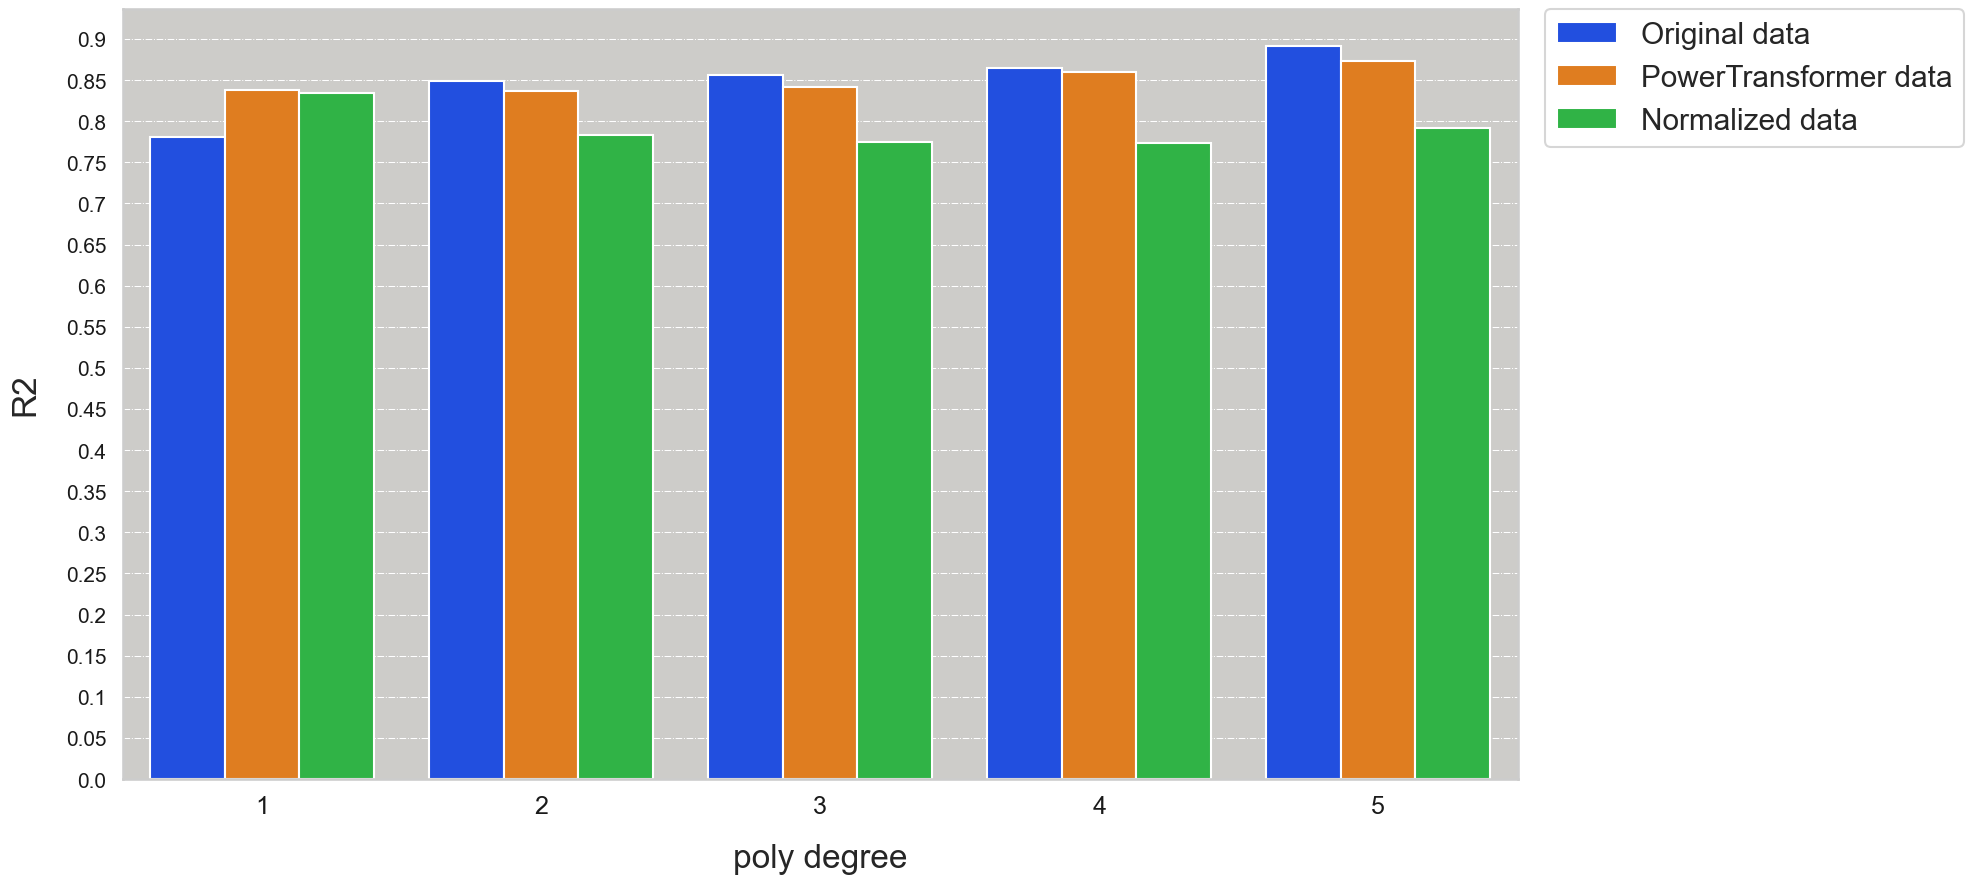

In [260]:
## Define extremal R2 values on y axis and show R2 values in the range <min;max> with step 0.05
y_max = np.round(df_regression_results['R2'].max(axis=0), 1)
y_ticks_pos = np.round(np.arange(0, y_max+0.05, 0.05), 2)


fig, ax = plt.subplots(figsize=(18, 10))
sns.set_theme(context='talk', style='whitegrid', palette='bright', font_scale=1.3)

sns.barplot(data=df_regression_results, x='poly degree', y='R2', hue='function name', ax=ax)
plt.yticks(ticks=y_ticks_pos, labels=y_ticks_pos, fontsize=15)
## Place legend outside the plot (top right corner)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [261]:
def best_results(df, func_name):
    _ = df[df['function name'] == func_name]
    table = _.nlargest(1, 'R2', keep='all')[['temperature', 'energy', 'energy predicted']]
    degree = _.nlargest(1, 'R2')['poly degree']
    return table, int(degree.values)

df_best_results, best_degree = best_results(df_regression_results, 'Original data')

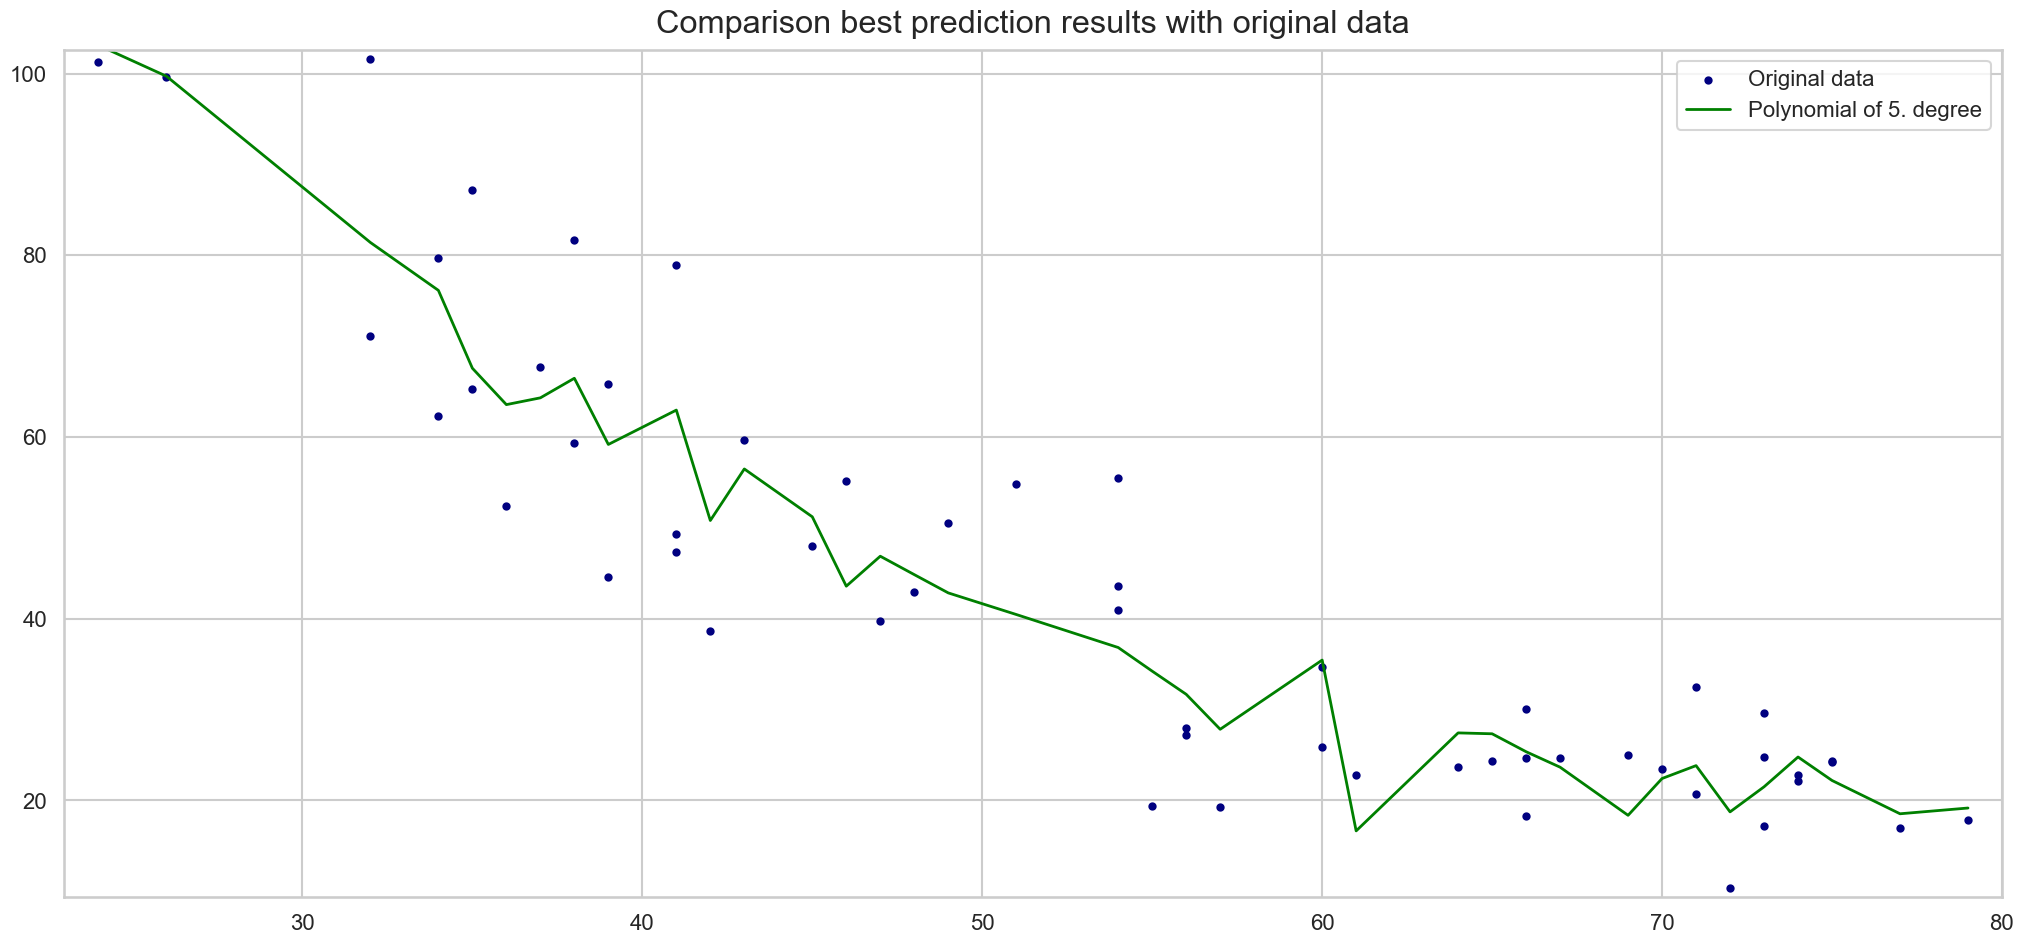

In [262]:
x_lim_1, x_lim_2 = df_best_results['temperature'].min() - 1, df_best_results['temperature'].max() + 1
y_lim_1, y_lim_2 = df_best_results['energy'].min() - 1, df_best_results['energy'].max() + 1

# To make properly plot we need unique energy value for every temperature and sort all data by this temperature
df_best_results_sorted = df_best_results.groupby(['temperature'], as_index=False).mean().sort_values(by=['temperature'])

fig, ax = plt.subplots(figsize=(25, 11))

plt.scatter(x=energy['temperature'], y=energy['electricity_usage'], s=20, c='navy', label='Original data')
plt.plot(df_best_results_sorted['temperature'], df_best_results_sorted['energy predicted'], aa=True,
         color='green', lw=2, label=f'Polynomial of {best_degree}. degree')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim((x_lim_1, x_lim_2))
plt.ylim((y_lim_1, y_lim_2))
plt.legend(fontsize=16)
plt.title('Comparison best prediction results with original data')
plt.show()